In [1]:
### This notebook is used for generating plots of music video network for our work. 

### In order to run the code, download network_pickle.tar.bz2 and vevo_en_videos_60k.tar.bz2 from https://drive.google.com/drive/folders/19R3_2hRMVqlMGELZm47ruk8D9kqJvAmL?usp=sharing
### Extract network_pickle_{0}.pkl from network_pickle.tar.bz2 to 'data/network_pickle'.
### Extract vevo_en_videos_60k.json from vevo_en_videos_60k.tar.bz2 to 'data/'.

### Author: Yutian Zhao
### Reference:
### Some parts of the code depend on Siqi Wu's code: https://github.com/avalanchesiqi/networked-popularity

<h1> Generate plots </h1>

In [2]:
import argparse, os, pickle, json, platform
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
from datetime import datetime, timedelta
from scipy.stats import pearsonr, percentileofscore
from powerlaw import plot_ccdf
from collections import Counter, defaultdict
import matplotlib as mpl
# if platform.system() == 'Linux':
#     mpl.use('Agg')  # no UI backend
# mpl.use('svg')
mpl.rcParams['lines.linewidth'] = 1
import matplotlib.pyplot as plt
from utils.data_loader import DataLoader
from utils.plot import ColorPalette, mean_plot, mean_scatter, plot_cumulative
from utils.helper import is_same_genre, gini, Timer
from utils.bridges import lost_nodes, strong_edges


In [3]:
## Total running time: 
## First time: 20~30min
## Afterwards: 5 min
# big_timer = Timer()
# big_timer.start()

In [4]:
NUM_REL = 15
T = 63
SAMPLE_DAY = 0 # DAY 0
data_prefix = 'data'

In [5]:
def cal_stats(lst, lst2):
    return [np.around(i, 2) for i in [np.min(lst), np.max(lst), np.mean(lst), np.std(lst), pearsonr(lst2, lst)[0]]]

def choice(s):
    # choose one element from set
    v = s.pop()
    s.add(v)
    return v

In [6]:
# == == == == == == Load data == == == == == == #
## Input file: 'data/vevo_forecast_data_60k.tsv', 'data/vevo_en_videos_60k.json'
## Time: 30s
data_loader = DataLoader()
data_loader.load_embed_content_dict()
num_videos = data_loader.num_videos
embed_avg_view_dict = data_loader.embed_avg_view_dict
embed_title_dict = data_loader.embed_title_dict
embed_cid_dict = data_loader.embed_cid_dict
embed_all_genre_dict = data_loader.embed_all_genre_dict

>>> Daily view data has been loaded!


In [7]:
# == == == == == == Construct music video network for each day == == == == == == #
## Input file: 'data/network_pickle/network_{0}.p'
## Output file: 'data/video_network.pkl'
## Time: 30s/3.5min
print(">>> Loading network data...")
if not os.path.exists(os.path.join(data_prefix, "video_network.pkl")):
    graph_lst = []
    edges = []
    # load data
    for t in tqdm(range(T)):
        filename = 'network_{0}.p'.format((datetime(2018, 9, 1) + timedelta(days=t)).strftime('%Y-%m-%d'))
        daily_edges = []
        with open(os.path.join(data_prefix, 'network_pickle', filename), 'rb') as fin:
            network_dict = pickle.load(fin)   # embed_tar: [(embed_src, pos_src, view_src), ...]
            for tar_embed in range(num_videos):
                for x in network_dict[tar_embed]:
                    if x[1] < NUM_REL:
                        daily_edges.append((x[0], tar_embed))
        edges.append(daily_edges)
    # construct network
    for i in edges:
        G = nx.DiGraph()
        G.add_edges_from(i)
        graph_lst.append(G)

    with open(os.path.join(data_prefix, "video_network.pkl"), 'wb') as fout:
        pickle.dump(graph_lst, fout)
else:
    with open(os.path.join(data_prefix, "video_network.pkl"), 'rb') as fin:
        graph_lst = pickle.load(fin)
print('>>> Graph has been constructed.')

>>> Loading network data...
>>> Graph has been constructed.


In [8]:
# == == == == == == Build lists == == == == == == #
print(">>> Building lists...")
## Avg. views
avg_view_list = []
for i in range(num_videos):
    avg_view_list.append(embed_avg_view_dict[i])
avg_view_list = np.array(avg_view_list)
avg_view_sort_ind = np.argsort(avg_view_list)
sorted_avg_view_list = avg_view_list[avg_view_sort_ind]

## Avg. indegree list
## Time: 7s
indegree_lists = []
for i in range(T):
    indegree_list = []
    for j in range(num_videos):
        if graph_lst[i].has_node(j):
            indegree_list.append(graph_lst[i].in_degree(j))
        else:
            indegree_list.append(0)
    indegree_lists.append(indegree_list)
indegree_lists = np.array(indegree_lists)
avg_ind_list = np.mean(indegree_lists, axis=0)

## Avg. clustering coefficient
## Input file: 'data/cc_list_15.pkl' (if exists)
## Output file: 'data/cc_list_15.pkl' (if doesn't exist)
## Time: 1s/5 min
if not os.path.exists(os.path.join(data_prefix, "cc_lists_15.pkl")):
    cc_lists = []
    for i in tqdm(range(T)):
        cc_list = []
        for j in range(num_videos):
            if graph_lst[i].has_node(j):
                cc_list.append(nx.clustering(graph_lst[i], j))
            else:
                cc_list.append(0)
        cc_lists.append(cc_list)
    cc_lists = np.array(cc_lists)
    with open(os.path.join(data_prefix, "cc_lists_15.pkl"), 'wb') as fout:
            pickle.dump(cc_lists, fout)
else:
    with open(os.path.join(data_prefix, "cc_lists_15.pkl"), 'rb') as fin:
        cc_lists = pickle.load(fin)
avg_cc_list = np.mean(cc_lists, axis=0)

## Avg. nearest neighbour indegree
## i.e. average indegree of incoming nodes
## Time: 1 min
avg_neighbour_ind_lst = np.zeros(num_videos)
for i in range(T):
    for v in graph_lst[i].nodes():
        neighbour_inds = []
        for j in graph_lst[i].predecessors(v):
            neighbour_inds.append(graph_lst[i].in_degree(j))
        if len(neighbour_inds) == 0:
            avg_neighbour_ind = 0
        else:
            avg_neighbour_ind = np.mean(neighbour_inds)
        avg_neighbour_ind_lst[v] += avg_neighbour_ind
avg_neighbour_ind_lst = avg_neighbour_ind_lst/T

## Avg. nearest neighbour views
## i.e. average views of incoming nodes
## Time: 1 min
avg_neighbour_view_lst = np.zeros(num_videos)
for i in range(T):
    for v in graph_lst[i].nodes():
        neighbour_views = []
        for j in graph_lst[i].predecessors(v):
            neighbour_views.append(embed_avg_view_dict[j])
        if len(neighbour_views) == 0:
            avg_neighbour_views = 0
        else:
            avg_neighbour_views = np.mean(neighbour_views)
        avg_neighbour_view_lst[v] += avg_neighbour_views
avg_neighbour_view_lst = avg_neighbour_view_lst/T

## Same artist/genre percentage
## i.e. percentage of indegrees from the same artist/genre
## Time: 30s
same_artist_percentage_list = np.zeros(num_videos)
same_genre_percentage_list = np.zeros(num_videos)
for i in range(T):
    for v in graph_lst[i].nodes():
        ind = 0
        same_artist_ind = 0
        same_genre_ind = 0
        for j in graph_lst[i].predecessors(v):
            ind += 1
            if embed_cid_dict[v] == embed_cid_dict[j]:
                same_artist_ind+=1
            if is_same_genre(embed_all_genre_dict[v], embed_all_genre_dict[j]):
                same_genre_ind+=1
        if ind != 0:
            same_artist_percentage_list[v]+=same_artist_ind/ind
            same_genre_percentage_list[v]+=same_genre_ind/ind                
same_artist_percentage_list = same_artist_percentage_list/T
same_genre_percentage_list = same_genre_percentage_list/T

## (Largest) connected component lists
scc_list = [nx.strongly_connected_components(G) for G in graph_lst]
lscc_list = [max(scc, key=len) for scc in scc_list] 

print(">>> Lists have been built.")

>>> Building lists...
>>> Lists have been built.


In [9]:
# == == == == == == Table 1. Summary statistics (over 63 days) == == == == == == #
## Time: 2s
stats_table = []
for lst in [avg_ind_list, avg_cc_list, avg_neighbour_ind_lst, same_artist_percentage_list, same_genre_percentage_list]:
    stats_table.append(cal_stats(lst, avg_view_list))
df = pd.DataFrame(stats_table, ['Avg. indegree', 'Avg. clustering coefficient', 'Avg. neighbour indegree', 'Same artist percentage', 'Same genre percentage'], ['Min', 'Max', 'Mean', 'Std', 'Correlation with views'])
print(df)
print('Number of nodes: ', num_videos)
avg_num_edges = np.mean([G.number_of_edges() for G in graph_lst])
print('Average number of edges: {0:.0f}'.format(avg_num_edges))


                             Min     Max  Mean    Std  Correlation with views
Avg. indegree                0.0  870.62  5.98  20.83                    0.54
Avg. clustering coefficient  0.0    0.96  0.15   0.11                   -0.09
Avg. neighbour indegree      0.0   61.64  2.25   3.04                    0.22
Same artist percentage       0.0    1.00  0.54   0.38                   -0.07
Same genre percentage        0.0    1.00  0.54   0.39                    0.06
Number of nodes:  60740
Average number of edges: 362965


In [10]:
# == == == == == == Construct persistent network == == == == == == #
## Input file: 'models/forecast_tracker_all.json', 'data/persistent_network.csv'
## Time: 1s
print(">>> Loading persistent network data...")
embed_ratio_dict = {}
arnet_weights = dict()
with open(os.path.join('models', 'forecast_tracker_all.json'), 'r') as fin:
    for line in fin:
        result_json = json.loads(line.rstrip())
        tar_embed = result_json['embed']
        embed_ratio_dict[tar_embed] = result_json['net_ratio']
        src_embed = result_json['incoming_embeds']
        link_weights = result_json['link_weights']
        for i, s in enumerate(src_embed):
            arnet_weights[(s, tar_embed)] = link_weights[i]

persistent_graph = nx.DiGraph()
with open(os.path.join(data_prefix, 'persistent_network.csv'), 'r') as fin:
    fin.readline()
    for line in fin:
        src_embed, tar_embed = map(int, line.rstrip().split(','))
        edge_weight = arnet_weights[(src_embed, tar_embed)]*embed_avg_view_dict[src_embed]
        persistent_graph.add_edge(src_embed, tar_embed, weight=edge_weight)

persistent_ids=np.array(list(embed_ratio_dict.keys())) # only incoming nodes
ratio_list = np.array([embed_ratio_dict[i] for i in persistent_ids])
persistent_avg_cc_list = avg_cc_list[persistent_ids]
persistent_avg_ind_list = avg_ind_list[persistent_ids]
persistent_avg_neighbour_ind_lst = avg_neighbour_ind_lst[persistent_ids]
persistent_avg_view_list = avg_view_list[persistent_ids]
persistent_same_artist_percentage_list = same_artist_percentage_list[persistent_ids]
persistent_same_genre_percentage_list = same_genre_percentage_list[persistent_ids]
persistent_avg_view_list_no_network = (1-ratio_list)*persistent_avg_view_list

print(">>> Persistent network has been constructed.")

>>> Loading persistent network data...
>>> Persistent network has been constructed.


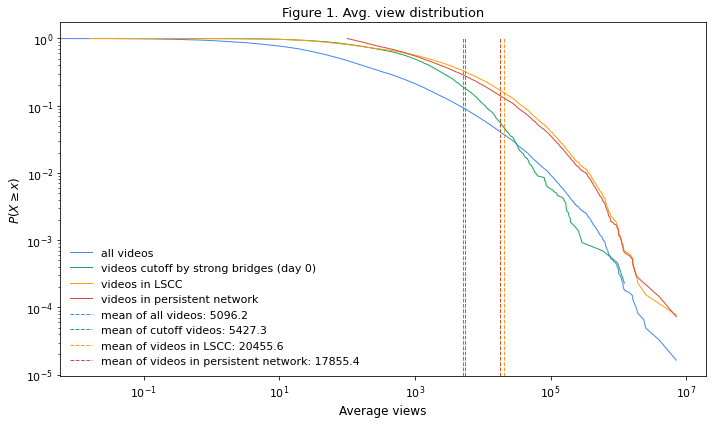

In [11]:
# == == == == == == Figure 1. Average view distribution == == == == == == #
## Input file: 'data/lost_nodes_0.pkl' (if exists)
## Output file: 'data/lost_nodes_0.pkl' (if doesn't exist)
## Time: 1s/7min
## lost_nodes_avg_views (day 0)
if SAMPLE_DAY != 0 or not os.path.exists(os.path.join(data_prefix, "lost_nodes_0.pkl")):
    sample_subgraph = graph_lst[SAMPLE_DAY].subgraph(lscc_list[SAMPLE_DAY]) # day 0
    bridges = strong_edges(choice(lscc_list[SAMPLE_DAY]), sample_subgraph)
    lost_nodes_list = lost_nodes(bridges, sample_subgraph, graph_lst[SAMPLE_DAY], "strong")            
    with open(os.path.join(data_prefix, "lost_nodes_0.pkl"), 'wb') as fout:
        pickle.dump(lost_nodes_list, fout)
else:
    with open(os.path.join(data_prefix, "lost_nodes_0.pkl"), 'rb') as fin:
        lost_nodes_list = pickle.load(fin)

lost_nodes_avg_views = [np.mean([embed_avg_view_dict[i] for i in lst]) for lst in lost_nodes_list]

## lscc avg. views (day 0)
sample_lscc_avg_views = [embed_avg_view_dict[v] for v in lscc_list[SAMPLE_DAY]]

## plot
fig, ax1 = plt.subplots(figsize=(10,6))
plot_ccdf(avg_view_list, ax=ax1, label='all videos' ,color=ColorPalette.CC4[0])
plot_ccdf(lost_nodes_avg_views, ax=ax1, label='videos cutoff by strong bridges (day 0)',color=ColorPalette.CC4[1])
plot_ccdf(sample_lscc_avg_views, ax=ax1, label='videos in LSCC', color=ColorPalette.CC4[2])
plot_ccdf(persistent_avg_view_list, ax=ax1, label='videos in persistent network', color=ColorPalette.CC4[3])

ax1.vlines(np.mean(avg_view_list), 0, 1, linestyle='dashed', color=ColorPalette.CC4[0], label='mean of all videos: {:.1f}'.format(np.mean(avg_view_list)))
ax1.vlines(np.mean(lost_nodes_avg_views), 0, 1, linestyle='dashed',color=ColorPalette.CC4[1], label='mean of cutoff videos: {:.1f}'.format(np.mean(lost_nodes_avg_views)))
ax1.vlines(np.mean(sample_lscc_avg_views), 0, 1, linestyle='dashed', color=ColorPalette.CC4[2], label='mean of videos in LSCC: {:.1f}'.format(np.mean(sample_lscc_avg_views)))
ax1.vlines(np.mean(persistent_avg_view_list), 0, 1, linestyle='dashed', color=ColorPalette.CC4[3], label='mean of videos in persistent network: {:.1f}'.format(np.mean(persistent_avg_view_list)))
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Average views', fontsize=12)
ax1.set_ylabel('$P(X \geq x)$', fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=11)
ax1.set_title('Figure 1. Avg. view distribution', fontsize=13)
ax1.legend(frameon=False, fontsize=11, ncol=1, fancybox=False, shadow=True)
plt.tight_layout()
plt.savefig(os.path.join('plots', "fig1_view_distribution.svg"), bbox_inches='tight')

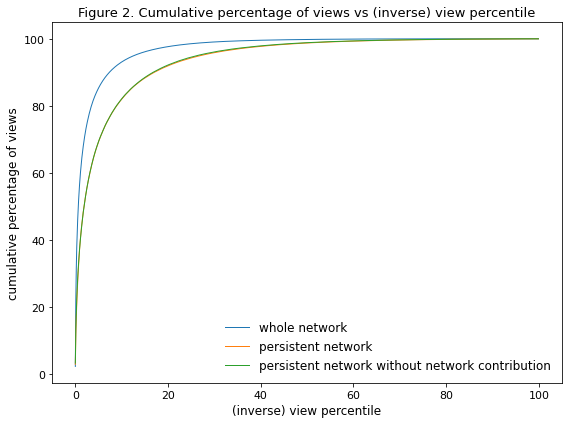

In [12]:
# == == == == == == Figure 2. Cumulative percentage of views vs (inverse) view percentile  == == == == == == #
## Time: 2s
plt.figure(figsize=(8, 6))
plot_cumulative(avg_view_list)
plot_cumulative(persistent_avg_view_list)
plot_cumulative(persistent_avg_view_list_no_network)
plt.xlabel("(inverse) view percentile", fontsize=12)
plt.ylabel("cumulative percentage of views", fontsize=12)
plt.title("Figure 2. Cumulative percentage of views vs (inverse) view percentile", fontsize=13)
plt.legend(["whole network", "persistent network", "persistent network without network contribution"], frameon=False, fontsize=12, ncol=1, fancybox=False, shadow=True)
plt.tick_params(axis='both', labelsize=11)
plt.tight_layout()
plt.savefig(os.path.join('plots', "fig2_view_cumulative.svg"), bbox_inches='tight')

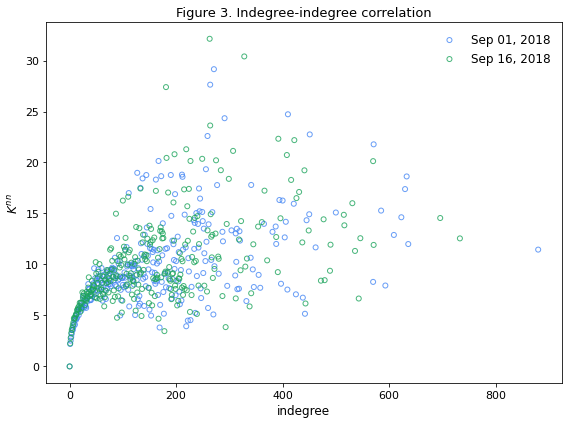

In [13]:
# == == == == == == Figure 3. Indegree-indegree correlation  == == == == == == #
## Time: 1s
plt.figure(figsize=(8, 6))
date_labels = ['Sep 01, 2018', 'Sep 16, 2018', 'Oct 01, 2018', 'Oct 16, 2018']
for i in [0, 15]:
    # calculate average nearest neighbor degree of nodes with degree k
    ind_dict = nx.k_nearest_neighbors(graph_lst[i], source='in', target='in')
    items = sorted(ind_dict.items(), key=lambda x:x[0])
    plt.scatter([ind for ind, _ in items], [knn for _, knn in items], color=ColorPalette.CC4[int(i/15)], s=25, marker='o', facecolors='none', alpha=0.8, label=date_labels[int(i/15)])

plt.xlabel('indegree', fontsize=12)
plt.ylabel('$K^{nn}$', fontsize=12)
plt.title('Figure 3. Indegree-indegree correlation', fontsize=13)
plt.legend(frameon=False, fontsize=12, ncol=1, fancybox=False, shadow=True)
plt.tick_params(axis='both', labelsize=11)
plt.tight_layout()
plt.savefig(os.path.join('plots', "fig3_indegree_correlation.svg"), bbox_inches='tight')

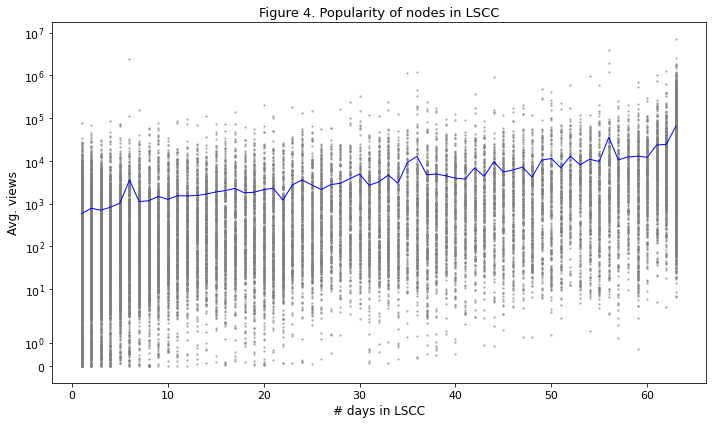

In [14]:
# == == == == == == Figure 4. Popularity of nodes in LSCC == == == == == == #
## Time: 2s
counter = Counter()
for lscc in lscc_list:
    counter.update(lscc)

lscc_avg_views = []  # avg. views of nodes in lscc
days_in_lscc = []
for i in counter.keys():
    lscc_avg_views.append(embed_avg_view_dict[i])
    days_in_lscc.append(counter[i])

plt.figure(figsize=(10,6))  #   
mean_plot(days_in_lscc, lscc_avg_views)
plt.title("Figure 4. Popularity of nodes in LSCC", fontsize=13)
plt.xlabel("# days in LSCC", fontsize=12)
plt.ylabel("Avg. views", fontsize=12)
plt.yscale('symlog')
plt.tick_params(axis='both', labelsize=11)
plt.tight_layout()
plt.savefig(os.path.join('plots', "fig4_lscc_popularity.svg"), bbox_inches='tight')

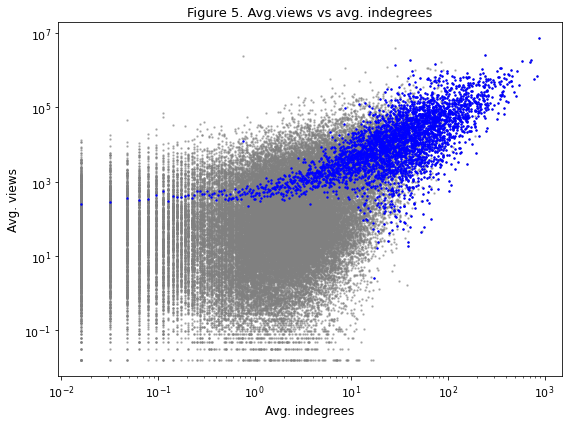

In [15]:
# == == == == == == Figure 5. Avg.views vs avg. indegrees == == == == == == #
## Time: 3s
plt.figure(figsize=(8,6))
mean_scatter(avg_ind_list, avg_view_list)
plt.title("Figure 5. Avg.views vs avg. indegrees", fontsize=13)
plt.xlabel("Avg. indegrees", fontsize=12)
plt.ylabel("Avg. views", fontsize=12)
plt.tick_params(axis='both', labelsize=11)
plt.xscale("log")
plt.yscale("log")
plt.tight_layout()
plt.savefig(os.path.join('plots', "fig5_view_indegree.svg"), bbox_inches='tight')

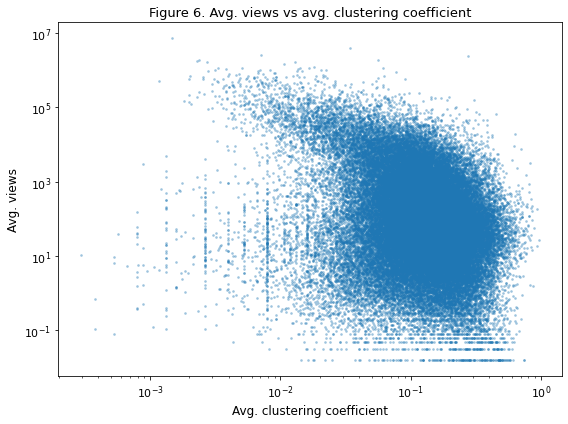

In [16]:
# == == == == == == Figure 6. Avg.views vs avg. clustering coefficient == == == == == == #
## Time: 3s
plt.figure(figsize=(8,6))
plt.scatter(avg_cc_list, avg_view_list, s=3, alpha=0.3)
plt.xscale("log")
plt.yscale("log")
plt.title("Figure 6. Avg. views vs avg. clustering coefficient", fontsize=13)
plt.xlabel("Avg. clustering coefficient", fontsize=12)
plt.ylabel("Avg. views", fontsize=12)
plt.tick_params(axis='both', labelsize=11)
plt.tight_layout()
plt.savefig(os.path.join('plots', "fig6_view_cluster.svg"), bbox_inches='tight')

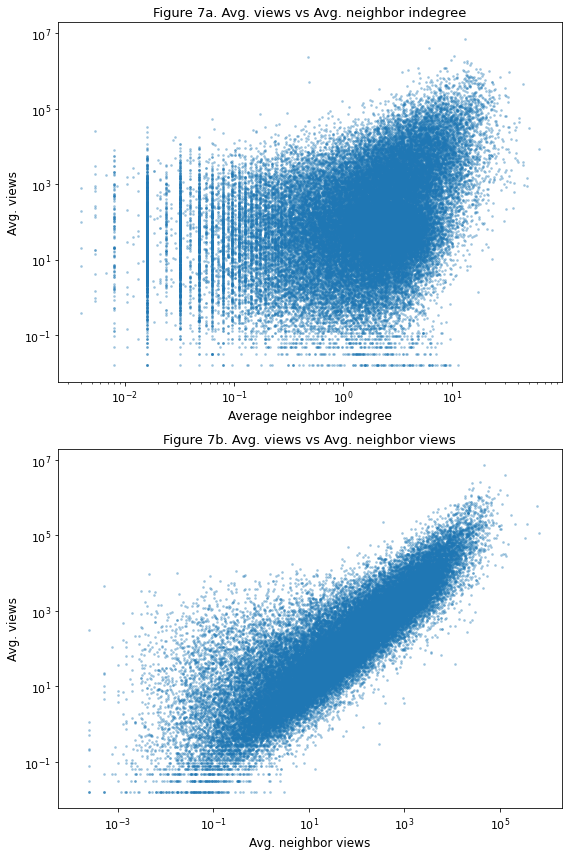

In [17]:
# == == == == == == Figure 7. Avg.views vs avg. indegree/views of neighbours == == == == == == #
## Time: 5s
plt.figure(figsize=(8,12))

# Avg.views vs avg. indegree of neighbours
plt.subplot(2,1,1)
plt.scatter(avg_neighbour_ind_lst, avg_view_list, s=3, alpha=0.3)
plt.title("Figure 7a. Avg. views vs Avg. neighbor indegree", fontsize=13)
plt.xlabel("Average neighbor indegree", fontsize=12)
plt.ylabel("Avg. views", fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='both', labelsize=11)

# Avg.views vs avg. views of neighbours
plt.subplot(2,1,2)
plt.scatter(avg_neighbour_view_lst, avg_view_list, s=3, alpha=0.3)
plt.title("Figure 7b. Avg. views vs Avg. neighbor views", fontsize=13)
plt.xlabel("Avg. neighbor views", fontsize=12)
plt.ylabel("Avg. views", fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='both', labelsize=11)

plt.tight_layout()
plt.savefig(os.path.join('plots', "fig7_view_neighbour.svg"), bbox_inches='tight')

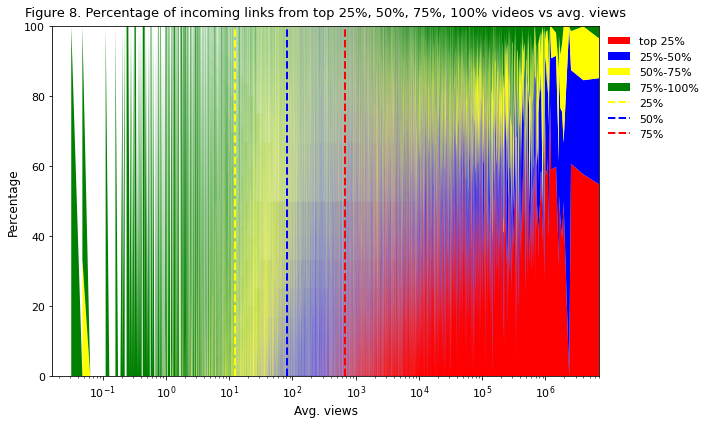

In [18]:
# == == == == == == Figure 8. Percentage of incoming links from top 25%, 50%, 75%, 100% videos == == == == == == #
## Time: 40s
# videos are categorized into 4 groups based on view counts
# count number of edges from top 25%, 25%-50%, 50%-75%, 75%-100% videos
from_top_25_ind_list = []
from_top_50_ind_list = []
from_top_75_ind_list = []
from_top_100_ind_list = []
for i in range(num_videos):
    from_top_25_ind = 0
    from_top_50_ind = 0
    from_top_75_ind = 0
    from_top_100_ind = 0

    if graph_lst[SAMPLE_DAY].has_node(i):
        ind = 0
        for p in graph_lst[SAMPLE_DAY].predecessors(i):
            percentile = percentileofscore(avg_view_list, embed_avg_view_dict[p])
            ind += 1 
            if percentile<=25:
                from_top_100_ind+=1
            elif percentile<=50:
                from_top_75_ind+=1
            elif percentile<=75:
                from_top_50_ind+=1
            else:
                from_top_25_ind+=1
        if ind != 0:
            from_top_25_ind = 100*from_top_25_ind/ind
            from_top_50_ind = 100*from_top_50_ind/ind
            from_top_75_ind = 100*from_top_75_ind/ind
            from_top_100_ind = 100*from_top_100_ind/ind
            
    from_top_25_ind_list.append(from_top_25_ind)
    from_top_50_ind_list.append(from_top_50_ind)
    from_top_75_ind_list.append(from_top_75_ind)
    from_top_100_ind_list.append(from_top_100_ind)
    
from_top_25_ind_list_sorted = np.array(from_top_25_ind_list)[avg_view_sort_ind]
from_top_50_ind_list_sorted = np.array(from_top_50_ind_list)[avg_view_sort_ind]
from_top_75_ind_list_sorted = np.array(from_top_75_ind_list)[avg_view_sort_ind]
from_top_100_ind_list_sorted = np.array(from_top_100_ind_list)[avg_view_sort_ind]

# plot
plt.figure(figsize=(10, 6))
plt.stackplot(sorted_avg_view_list, from_top_25_ind_list_sorted, from_top_50_ind_list_sorted, from_top_75_ind_list_sorted, from_top_100_ind_list_sorted,\
             labels=["top 25%", "25%-50%", "50%-75%", "75%-100%"] ,colors=["red", "blue", 'yellow','green'],)
plt.vlines(np.percentile(sorted_avg_view_list, 25), 0, 100, linestyle='dashed', color='yellow', label='25%', linewidths=2)
plt.vlines(np.percentile(sorted_avg_view_list, 50), 0, 100, linestyle='dashed', color='blue', label='50%', linewidths=2)
plt.vlines(np.percentile(sorted_avg_view_list, 75), 0, 100, linestyle='dashed', color='red', label='75%', linewidths=2)
plt.title("Figure 8. Percentage of incoming links from top 25%, 50%, 75%, 100% videos vs avg. views", fontsize=13, pad=10)
plt.xlabel("Avg. views", fontsize=12)
plt.ylabel("Percentage", fontsize=12)
plt.xscale('log')
plt.autoscale(enable=True, axis='both', tight=True)
plt.legend(bbox_to_anchor=(1.2, 1), frameon=False, fontsize=11, ncol=1, fancybox=False, shadow=True)
plt.tick_params(axis='both', labelsize=11)
plt.tight_layout()
plt.savefig(os.path.join('plots', "fig8_view_percentage.svg"), bbox_inches='tight')


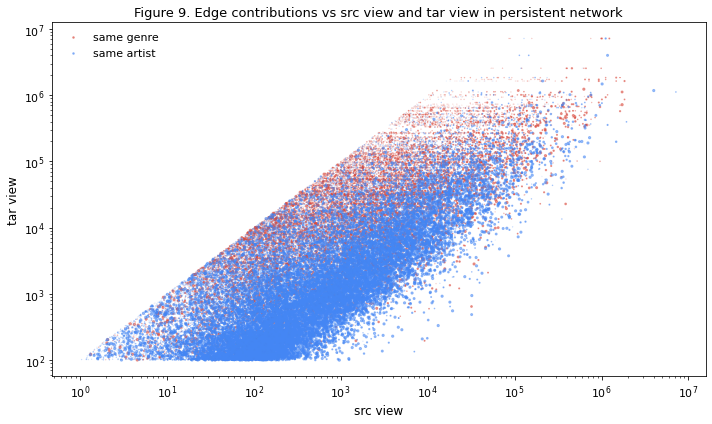

In [27]:
# == == == == == == Figure 9. Edge contributions vs source video views and target video views in persistent network == == == == == == #
## Input file: 'data/persistent_network.csv'
## Time: 10s
# the total view contribution the video gets from the network
contributed_views = []
for i in persistent_ids:
    view = 0
    for p in persistent_graph.predecessors(i):
        avg_view = embed_avg_view_dict[p]
        view += avg_view*arnet_weights[(p, i)]
    contributed_views.append(view)
    
# view lists of source/target videos from the same/different artists/genres
sa_sg_src_list = []
sa_sg_tar_list = []
sa_dg_src_list = []
sa_dg_tar_list = []
da_sg_src_list = []
da_sg_tar_list = []
da_dg_src_list = []
da_dg_tar_list = []
# weight lists of edges from the same/different artists/genres
sa_sg_weight_list = []
sa_dg_weight_list = []
da_sg_weight_list = []
da_dg_weight_list = []

with open(os.path.join(data_prefix, 'persistent_network.csv'), 'r') as fin:
    fin.readline()
    for line in fin:
        src_embed, tar_embed = map(int, line.rstrip().split(','))
        edge_weight = arnet_weights[(src_embed, tar_embed)]
        tar_ind = np.nonzero(persistent_ids==tar_embed)[0][0]
        # weight is calculated as the percentage of the edge contribution w.r.t the total network contribution the video gets
        if edge_weight*embed_avg_view_dict[src_embed] > 0:
            weight = edge_weight*embed_avg_view_dict[src_embed]/contributed_views[tar_ind]
        else:
            weight = 0  # there are negative numbers close to 0 due to numnerical errors
        weight = weight*5  # enlarge to appropriate size
        
        if (embed_cid_dict[src_embed] == embed_cid_dict[tar_embed]) and is_same_genre(embed_all_genre_dict[src_embed], embed_all_genre_dict[tar_embed]):
            
            sa_sg_src_list.append(embed_avg_view_dict[src_embed])
            sa_sg_tar_list.append(embed_avg_view_dict[tar_embed])
            sa_sg_weight_list.append(weight)

        elif (embed_cid_dict[src_embed] != embed_cid_dict[tar_embed]) and is_same_genre(embed_all_genre_dict[src_embed], embed_all_genre_dict[tar_embed]):
            da_sg_src_list.append(embed_avg_view_dict[src_embed])
            da_sg_tar_list.append(embed_avg_view_dict[tar_embed])
            da_sg_weight_list.append(weight)

        elif (embed_cid_dict[src_embed] == embed_cid_dict[tar_embed]) and not is_same_genre(embed_all_genre_dict[src_embed], embed_all_genre_dict[tar_embed]):
            sa_dg_src_list.append(embed_avg_view_dict[src_embed])
            sa_dg_tar_list.append(embed_avg_view_dict[tar_embed])
            sa_dg_weight_list.append(weight)

        else:
            da_dg_src_list.append(embed_avg_view_dict[src_embed])
            da_dg_tar_list.append(embed_avg_view_dict[tar_embed])
            da_dg_weight_list.append(weight)
            
# plot
plt.figure(figsize=(10, 6))
plt.scatter(da_sg_src_list+da_dg_src_list, da_sg_tar_list+da_dg_tar_list, s=da_sg_weight_list+da_dg_weight_list, c=ColorPalette.CC4[3], label='same genre', marker='o', alpha=0.5)
plt.scatter(sa_dg_src_list+sa_sg_src_list, sa_dg_tar_list+sa_sg_tar_list, s=sa_dg_weight_list+sa_sg_weight_list, c=ColorPalette.CC4[0], label='same artist',marker='o', alpha=0.5)
plt.title("Figure 9. Edge contributions vs src view and tar view in persistent network", fontsize=13)
plt.xscale('log')
plt.yscale('log')
plt.legend(frameon=False, fontsize=11, ncol=1, fancybox=False, shadow=True)
plt.xlabel("src view", fontsize=12)
plt.ylabel("tar view", fontsize=12)
plt.tick_params(axis='both', labelsize=11)
plt.tight_layout()
plt.savefig(os.path.join('plots', "fig9_edge_contribution.svg"), bbox_inches='tight')

In [20]:
# big_timer.stop()

>>> Elapsed time: 0:05:02.999

